In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
from scipy.integrate import solve_bvp

Globals and Helpers

In [8]:
# We'll store baby sleep states and parent sleep states over time (discretized).
# We'll track "epsilon" variations cumulatively

total_eps = 0.0    # For tracking baby state randomness
sleep_tracker = [] # For storing the parent's sleep/awake state at each time step

# constants for cost calculation
K = 1.0 # factor for the denominator
alpha = 0.5 # scales Z(t)
delta_t = 1.0 # discrete time step (hours)

def eps_tracker(eps):
    """
    Accumulate the random perturbation (eps) to model unpredictability.
    We'll treat 'eps' as a single float, or an array chunk, 
    then return the updated total.
    """
    global total_eps
    total_eps += eps
    return total_eps

def parent_sleep_tracker(val):
    """
    Append the parent's sleep/awake state for the current time step.
    """
    global sleep_tracker
    sleep_tracker.append(val)
    return sleep_tracker

Modeling Functions

In [9]:
def delta(t):
    """
    Weighted coefficient for night vs. day:
      - 0.9 if 0 < t < 8 (Night)
      - 0.1 if 8 <= t <= 24 (Day)
    """
    if 0 < t < 8:
        return 0.9
    elif 8 <= t <= 24:
        return 0.1
    # Return something default if out of range:
    return 0.1

def B(t, eps):
    """
    Baby sleep state: 1 = baby asleep, 0 = baby awake.
    We incorporate an epsilon shift in t for unpredictability.
    
    we pass in a single eps or an array-based shift for discrete steps.

    We'll do a piecewise approach:
    - For 0..3 hours, baby is asleep (B=1).
    - For 3..4 hours, baby is awake (B=0).
    Then repeat every 4 hours with a shift by eps.
    """
    # Combine time with the epsilon shift:
    t_adj = t - eps  # Shift time by eps

    # Find a 4-hour block in which t_adj belongs:
    # We'll do mod 4 so it repeats:
    mod_block = t_adj % 4  # remainder in [0, 4)

    # If mod_block < 3 => baby asleep, else baby awake
    if 0 <= mod_block < 3:
        return 1
    else:
        return 0
    
def baby_state_array(T=24, dt=1.0):
    """
    Pre-compute the baby's state (awake/asleep) at each discrete time step
    using random eps shifts. Return a numpy array of length N,
    with baby[i] in {0, 1}
    """
    n_steps = int(T/dt)
    t_vals = np.arange(0, T+1e-9, dt)
    # we'll store an eps that drifts over time
    eps = 0.0
    eps_shifts = np.random.uniform(-0.5, 0.5, size=len(t_vals))

    baby_arr = []
    for i, t in enumerate(t_vals):
        eps += eps_shifts[i]
        # compute baby state
        mod_block = (t - eps) % 4
        if 0 <= mod_block < 3:
            baby_arr.append(1) # asleep
        else:
            baby_arr.append(0) # awake
    return np.array(baby_arr), t_vals

def w(t):
    """
    Placeholder function: Work or childcare obligations at time t.
    """
    return 0.0

def Z(t):
    """Random baby-driven disruptions or unpredictablity (placeholder)"""
    return np.random.normal(0, 0.1)

def compute_dp_np(u_array):
    """
    Given a discrete control array 'u_array' (0=awake,1=sleep), 
    return arrays dp_vals (uninterrupted sleep durations) and 
    np_vals (number of naps).
    """
    n = len(u_array)
    # Force 1D int64 arrays:
    dp_vals = np.zeros((n,), dtype=np.int64)
    np_vals = np.zeros((n,), dtype=np.int64)

    nap_count = 0
    for i in range(n):
        if i == 0:
            dp_vals[i] = u_array[i]
            nap_count = 1 if u_array[i] == 1 else 0
        else:
            if u_array[i] == 1:
                if u_array[i-1] == 1:
                    dp_vals[i] = dp_vals[i-1] + 1
                else:
                    dp_vals[i] = 1
                    nap_count += 1
            else:
                dp_vals[i] = 0
        np_vals[i] = nap_count

    return dp_vals, np_vals


def compute_cost(baby_arr, u_arr, dt=1.0):
    """
    Compute the discrete approximation of:
       J = sum over i of [ B_i*(dp_i^2/(K*np_i)) - w(t_i) + alpha*Z(t_i) ] * dt
    subject to the constraint: if baby=0 => u=0 forced.
    """
    n = len(baby_arr)
    # If baby is awake => enforce parent awake in the control array
    # ( parent can't sleep if baby is awake )
    for i in range(n):
        if baby_arr[i] == 0:
            u_arr[i] = 0

    dp_vals, np_vals = compute_dp_np(u_arr)
    cost_val = 0.0
    for i in range(n):
        # define integrand
        denom = K*(np_vals[i] if np_vals[i] > 0 else 1)
        integrand = baby_arr[i] * (dp_vals[i]**2 / denom) - w(i) + alpha*Z(i)
        cost_val += integrand*dt
    return cost_val

def u_control(t, baby_state):
    """
    The parent's control: 1 = parent chooses to sleep, 0 = parent chooses to be awake.
    This is where we can try our "optimal control" strategies or test strategies
    
    For now, the naive policy: 
    'Parent tries to sleep if baby is asleep (B=1) and it's night.'
    """
    if baby_state == 0:
        return 0  # Must be awake if baby is awake
    else:
        # baby is asleep => choose whether to sleep:
        if delta(t) > 0.5:
            # It's 'night': definitely sleep
            return 1
        else:
            # It's 'day': maybe partial logic, but let's just say sleep anyway
            return 1

Derived Quantities

In [10]:
def Dp(time_index):
    """
    Return the parent's uninterrupted sleep duration at discrete time step 'time_index'.
    We look backward in 'sleep_tracker' until we hit an awake state (0) or start of array.
    """
    if sleep_tracker[time_index] == 0:
        return 0
    # Accumulate how many consecutive steps of '1' up to time_index
    dur = 0
    for i in range(time_index, -1, -1):  # walk backward
        if sleep_tracker[i] == 1:
            dur += 1
        else:
            break
    return dur  # in discrete steps (hours, if dt=1)

def Np(time_index):
    """
    Return the number of distinct 'sleep intervals' from t0 up to time_index.
    We'll increment count each time we see a 0->1 transition in sleep_tracker.
    """
    if time_index <= 0:
        return 0
    num_naps = 0
    for i in range(1, time_index+1):
        if sleep_tracker[i] == 1 and sleep_tracker[i-1] == 0:
            num_naps += 1
    return num_naps

Discrete Simulation

In [11]:
def iterative_improvement(baby_arr, dt=1.0, max_iters=1000):
    """
    Local search approach:
      1) Start with a random feasible control array u_arr (0 or 1).
         (Must have u=0 if baby=0).
      2) Evaluate cost.
      3) Try flipping one entry from 1->0 or 0->1 if baby is asleep
         to see if cost improves.
      4) If it improves, keep it. Otherwise revert.
      5) Repeat until no improvement or max_iters reached.
    """
    n = len(baby_arr)
    # 1) Initialize
    # feasible init: parent sleeps if baby is asleep
    u_arr = np.where(baby_arr==1, 1, 0)
    best_cost = compute_cost(baby_arr, u_arr.copy(), dt)
    
    for _ in range(max_iters):
        # pick random index
        i = np.random.randint(0, n)
        if baby_arr[i] == 1:
            # we can try flipping from 1->0 or 0->1
            old_val = u_arr[i]
            new_val = 1 - old_val
            u_arr[i] = new_val
            new_cost = compute_cost(baby_arr, u_arr.copy(), dt)
            if new_cost > best_cost:
                # improvement => keep
                best_cost = new_cost
            else:
                # revert
                u_arr[i] = old_val
        # if baby_arr[i] == 0 => forced to 0, skip flipping

    return u_arr, best_cost

def simulate_day(dt=1, T=24):
    """
    Discrete simulation from t=0..T with step dt.
    We'll incorporate random eps for each step to shift baby's sleep block slightly.
    """
    global sleep_tracker, total_eps
    sleep_tracker = []
    total_eps = 0.0

    # Create a time array from 0..T in increments dt
    t_vals = np.arange(0, T+1e-9, dt)
    # For each step, draw a random shift in epsilon:
    eps_shifts = np.random.uniform(-0.5, 0.5, size=len(t_vals))

    baby_states = []  # For storing baby state
    parent_states = [] # For storing parent's chosen control
    dp_vals = []
    np_vals = []

    # We'll accumulate the discrete cost here
    cost_value = 0.0

    for i, t in enumerate(t_vals):
        # Accumulate epsilon:
        e = eps_tracker(eps_shifts[i])
        # baby state:
        b_state = B(t, e)
        baby_states.append(b_state)

        # parent's control 
        u_val = u_control(t, b_state)
        parent_sleep_tracker(u_val)
        parent_states.append(u_val)

        # now that we have updated sleep_tracker, we can compute Dp, Np:
        cur_dp = Dp(i)
        cur_np = Np(i)
        dp_vals.append(cur_dp)
        np_vals.append(cur_np)

        # Evaluate the integrand for the cost at this discrete step
        denom = K*(cur_np if cur_np>0 else 1)
        integrand = b_state * (cur_dp**2 / denom) - w(t) + alpha*Z(t)
        cost_value += integrand * dt

    return t_vals, baby_states, parent_states, dp_vals, np_vals, cost_value

Final best cost: 99.08641166714632
Control array: [0 1 1 1 0 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 0 1 1 1]


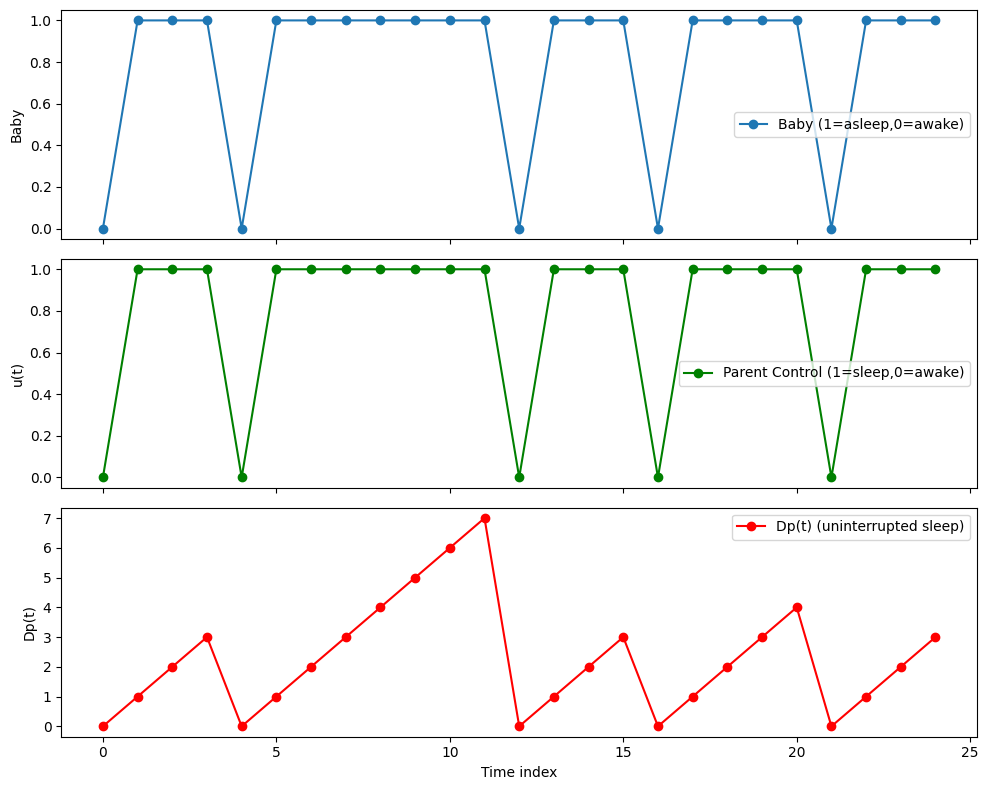

In [13]:
# step 1: get baby states
baby_arr, t_vals = baby_state_array(T=24, dt=1.0)
# step 2: run iterative improvement
u_best, cost_best = iterative_improvement(baby_arr, dt=1.0, max_iters=500)

print(f"Final best cost: {cost_best}")
print(f"Control array: {u_best}")
# let's look at dp, np, etc.
dp_vals, np_vals = compute_dp_np(u_best)

# quick plot
fig, ax = plt.subplots(3,1, figsize=(10,8), sharex=True)
ax[0].plot(t_vals, baby_arr, '-o', label='Baby (1=asleep,0=awake)')
ax[0].set_ylabel('Baby')
ax[0].legend()

ax[1].plot(t_vals, u_best, '-o', c='g', label='Parent Control (1=sleep,0=awake)')
ax[1].set_ylabel('u(t)')
ax[1].legend()

ax[2].plot(t_vals, dp_vals, '-o', c='r', label='Dp(t) (uninterrupted sleep)')
ax[2].set_ylabel('Dp(t)')
ax[2].set_xlabel('Time index')
ax[2].legend()

plt.tight_layout()
plt.show()